In [1]:
%matplotlib inline
# %matplotlib notebook
import rasterio
from rasterio.plot import show
from rasterio.coords import BoundingBox
from rasterio import windows
from rasterio import warp
from rasterio import mask
import numpy as np
import matplotlib.pyplot as plt
import rasterio.plot as plot
from matplotlib.patches import Rectangle
import matplotlib._color_data as mcd

from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
# from fiona.crs import from_epsg
# import pycrs

## Cargamos la imagen

In [2]:
url_imagen = '/home/diego/Downloads/03 PROYECTOS_UDEC-20190310T213801Z-001/03 PROYECTOS_UDEC/01_VIVERO/01_imagenes/imagen_mesones_rgb.tif'

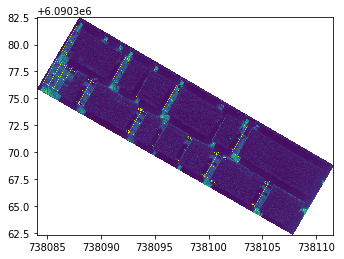

In [3]:
raster = rasterio.open(url_imagen)
show(raster)

In [4]:
print(raster.height,raster.width,raster.transform,raster.crs)

1823 2488 [738084.0554489046, 0.011059996684345716, 0.0, 6090382.5193425445, 0.0, -0.011059996684345716] CRS({'init': 'epsg:32718'})


## Tamaño de las ventanas

In [84]:
colores = list({name for name in mcd.CSS4_COLORS
           if "xkcd:" + name in mcd.XKCD_COLORS})
offsetX = 0
offsetY = 0
widthX = 100
widthY = 100
step = 10

1830 1823
2490 2488


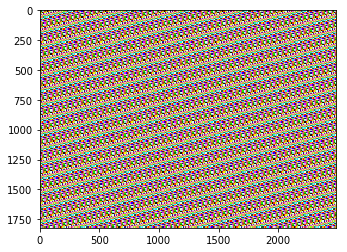

In [85]:
datos_b1 = raster.read(2)
plt.imshow(datos_b1)
ax = plt.gca()
contador = 0
while (1):
#     print(offsetY,offsetX,widthX,widthY)
    i_color = (contador)%len(colores)
   
    # finalizar si se a recorrido toda la imagen
    if(offsetY >= raster.height and offsetX >= raster.width):
        print(offsetY, raster.height)
        print(offsetX, raster.width)
        break
    #cuando llegue al borde en el eje x, debo bajar(sumar en eje y) y debo volver a empezar setear offsetX en 0 y widthX en 100
    elif(offsetX >= raster.width):
        offsetY = offsetY + step
        offsetX = 0
        widthX = 100 
    windows_list.append(windows.Window(offsetX,offsetY,widthX,widthY))
    ax.add_patch(Rectangle((windows_list[contador].col_off,windows_list[contador].row_off),
                       width=windows_list[contador].width,
                       height=windows_list[contador].height,fill=True,alpha=.9,
                 color=colores[i_color]))
    contador = contador + 1
    offsetX = offsetX + step 

# Seleccionamos un cuadro para graficar

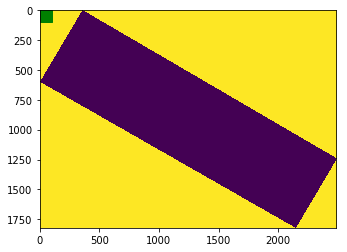

In [91]:
contador = indice
datos_b1 = raster.read(2)
plt.imshow(datos_b1)
ax = plt.gca()
# raster.xy(windows_list[contador].col_off, windows_list[contador].row_off )
ax.add_patch(Rectangle((windows_list[contador].col_off,windows_list[contador].row_off),
                       width=windows_list[contador].width,
                       height=windows_list[contador].height,fill=True,alpha=1,
                 color=colores[1]))

### vemos los pixeles

In [92]:
indice = 0
print(windows_list[indice].col_off)
print(windows_list[indice].row_off) 
print(windows_list[indice].width)
print(windows_list[indice].height)

0
0
100
100


### vemos las coordenada

In [93]:
t = raster.xy(windows_list[indice].row_off , windows_list[indice].col_off )
print(t)
l = raster.xy(windows_list[indice].row_off +windows_list[indice].width , windows_list[indice].col_off )
# print(l[0])
print(l)
r = raster.xy(windows_list[indice].row_off  , windows_list[indice].col_off + windows_list[indice].width)
# print(r[0])
print(r)
b = raster.xy(windows_list[indice].row_off + windows_list[indice].width , windows_list[indice].col_off +windows_list[indice].height)
# print(b[1])
print(b)

(738084.060978903, 6090382.513812546)
(738084.060978903, 6090381.407812878)
(738085.1669785714, 6090382.513812546)
(738085.1669785714, 6090381.407812878)


## Procedimiento para cortar
https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
    

In [89]:
#x
# l = 738092.9089762504
l=l[0]
# r = 738094.0149759189
r=r[0]
#y
# t = 6090373.665815198
t=t[1]
# b = 6090372.55981553
b=b[1]

minx,miny = (l,b)
maxx,maxy = (r,t)
#lbrt

In [90]:
print(l)
print(b)
print(r)
print(t)

738084.060978903
6090381.407812878
738085.1669785714
6090382.513812546


In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [80]:
bbox = box(minx, miny, maxx, maxy)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=raster.crs)
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[738094.0149759189, 6090372.55981553], [738094.0149759189, 6090373.665815198], [738092.9089762504, 6090373.665815198], [738092.9089762504, 6090372.55981553], [738094.0149759189, 6090372.55981553]]]}]


In [72]:
out_img, out_transform = mask(raster, shapes=coords, crop=True)
out_meta = raster.meta.copy()
out_meta.update({"driver": "GTiff",
      "height": 100,
      "width": 100,
      "transform": out_transform,
      "crs": raster.crs}
                          )

In [73]:
with rasterio.open("salida.tif", "w", **out_meta) as dest:
    dest.write(out_img)

In [76]:
out_meta.update({"driver": "JPEG",
      "height": 100,
      "width": 100,
      "transform": out_transform,
      "crs": raster.crs}
                          )

In [77]:
with rasterio.open("salida.jpg", "w", **out_meta) as dest:
    dest.write(out_img)